# Project 2: Advanced Lane Finding
### I follow roughly 6 steps to complete the project task:
   #### 1. Camera Calibration (once)
   #### 2. Distortion Correction
   #### 3. Color/gradient threshold
   #### 4. Perspective Transform
   #### 5. Detect lane lines
   #### 6. Determine Lane Curvature

In [80]:
#Header code -- import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
%matplotlib inline

### Step 1: Camera Calibration

In [64]:
#Step 1 -- Camera Calibration

def camera_cal():
    
    nx = 9 #number of corners across
    ny = 5 #number of corners down
    
    #FIND THE OBJECT AND IMAGE POINTS
    objpoints = []
    imgpoints = []
    
    ##Create objp array
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)    #x, y coordinates
    
    #BRING IN IMAGES
    images = glob.glob('camera_cal/calibration*.jpg')

    #CYCLE THRU CALIBRATION IMAGES
    for fname in images:
        #read in the image
        calibration_image = mpimg.imread(fname)
    
        #CONVERT TO GRAY
        gray = cv2.cvtColor(calibration_image, cv2.COLOR_RGB2GRAY)

        #FIND AND DRAW CORNERS
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
        ###append values if corners are found, and plot
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)
            new_image = cv2.drawChessboardCorners(calibration_image, (nx,ny), corners, ret)

    #GET CAMERA CALIBRATION VALUES
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None, None)

    return mtx, dist

#mtx, dist = camera_cal()

### Step 2: Distortion Correction

In [65]:
#Step 2 -- Correct for Distortion

def undist_img(image, mtx, dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

#image = mpimg.imread('camera_cal/calibration1.jpg')
#undist = undist_img(image, mtx, dist)
#plt.imshow(image)
#plt.figure()
#plt.imshow(undist)

### Step 3: Color/Gradient Threshold

#### The cell below was used for testing thresholds, color channels, and gradients, to find the best options for the next step of finding lane lines. This is why much is commented out.

In [92]:
#Step 3 -- Color/Gradient Threshold

def threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1)
    abs_sobel = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    thresh = [50,130]
    
    #sobel gradient threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #plt.figure()
    #plt.title('Sobel')
    #plt.imshow(sxbinary, cmap='gray')
    
    #RGB thresholds
    #R_channel = image[:,:,0]
    #r_thresh = [230,255]
    #Rbinary = np.zeros_like(R_channel)
    #Rbinary[(R_channel>=r_thresh[0])&(Rbinary<=r_thresh[1])] = 1
    #G_channel = image[:,:,1]
    #B_channel = image[:,:,2]
    #plt.figure()
    #plt.title('R channel')
    #plt.imshow(R_channel, cmap='gray')
    #plt.figure()
    #plt.title('R binary')
    #plt.imshow(Rbinary, cmap='gray')
    #plt.figure()
    #plt.title('G channel')
    #plt.imshow(G_channel, cmap='gray')
    #plt.figure()
    #plt.title('B channel')
    #plt.imshow(B_channel, cmap='gray')
    
    #HLS thresholds
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    #L_channel = hls[:,:,1]
    S_channel = hls[:,:,2]
    s_thresh = [180,255]
    Sbinary = np.zeros_like(S_channel)
    Sbinary[(S_channel>=s_thresh[0])&(Sbinary<=s_thresh[1])] = 1
    #plt.figure()
    #plt.title('S binary')
    #plt.imshow(Sbinary, cmap = 'gray')
    
    #combine the S and Sobel binary thresholds
    threshold_binary = np.zeros_like(Sbinary)
    threshold_binary[(Sbinary>=1)|(sxbinary>=1)] = 1
    
    return threshold_binary

#image = mpimg.imread('test_images/test3.jpg')
#image = undist_img(image, mtx, dist)
#threshold_image = threshold(image)
#plt.figure()
#plt.imshow(threshold_image, cmap='gray')

### Step 4: Perspective Transform

#### This first cell was used for testing on the straight line images, so that I could arrive at the best coordinates to use for the transformation. The second cell implements these coordinates within 2 functions to transform the image.

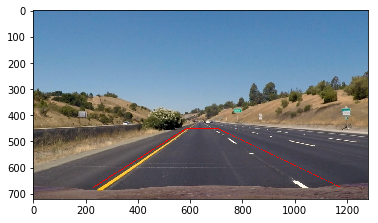

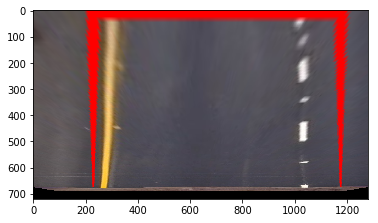

In [67]:
#Perspective transform testing

image = mpimg.imread('test_images/straight_lines1.jpg')
point_1 = (230,675)
point_2 = (587,450)
point_3 = (703,450)
point_4 = (1175, 675)
mappoint_2 = (230,0)
mappoint_3 = (1175,0)
cv2.line (image, point_1, point_2,(255,0,0),2)
cv2.line (image, point_2, point_3,(255,0,0),2)
cv2.line (image, point_3, point_4,(255,0,0),2)
plt.figure()
plt.imshow(image)

src = np.float32([point_1,point_2,point_3,point_4])
#mapped points
dst = np.float32([point_1,mappoint_2,mappoint_3,point_4])
#M matrix
M = cv2.getPerspectiveTransform(src, dst)
img_size = image.shape
#perspective transform
warped = cv2.warpPerspective(image, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(warped)

In [68]:
#Step 4 -- Perspective Transform

def persp_const():
    #identify source points
    src = np.float32([(230,675),(587,450),(703,450),(1175,675)])
    #mapped points
    dst = np.float32([[230,675],[230,0],[1175,0],[1175,675]])
    #M matrix & Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def persp_xform(image, img_size):
    #get transformation matrix, M
    M, Minv = persp_const()
    #perspective transform
    warped = cv2.warpPerspective(image, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)
    return warped

#top_down = persp_xform(threshold_image, img_size)
#plt.figure
#plt.imshow(threshold_image, cmap='gray')
#plt.figure()
#plt.imshow(top_down, cmap='gray')

### Step 5: Lane Line Detection

In [69]:
#Step 5 -- Detect Lane Lines

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ###Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_lane = leftx[0]   #pixel value where the left lane starts
    right_lane = rightx[0] #pixel value where the right lane starts

    return leftx, lefty, rightx, righty, left_lane, right_lane

#fit a polynomial to the found points describing lanes
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, left_lane, right_lane = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    ##Smooth the polynomials over the past few frames##new
    global left_fit_hist1
    global left_fit_hist2
    global left_fit_hist3
    global right_fit_hist1 
    global right_fit_hist2 
    global right_fit_hist3 
    left_fit_hist1 = np.append(left_fit_hist1,left_fit[0])
    left_fit_hist2 = np.append(left_fit_hist2,left_fit[1])
    left_fit_hist3 = np.append(left_fit_hist3,left_fit[2])
    right_fit_hist1 = np.append(right_fit_hist1,right_fit[0])
    right_fit_hist2 = np.append(right_fit_hist2,right_fit[1])
    right_fit_hist3 = np.append(right_fit_hist3,right_fit[2])
    left_fit[0] = smoothing(left_fit[0],left_fit_hist1)
    left_fit[1] = smoothing(left_fit[1],left_fit_hist2)
    left_fit[2] = smoothing(left_fit[2],left_fit_hist3)
    right_fit[0] = smoothing(right_fit[0],right_fit_hist1)
    right_fit[1] = smoothing(right_fit[1],right_fit_hist2)
    right_fit[2] = smoothing(right_fit[2],right_fit_hist3)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        #left_fitx = 1*ploty**2 + 1*ploty
        #right_fitx = 1*ploty**2 + 1*ploty
        
    return ploty, left_fit, right_fit, left_lane, right_lane, left_fitx, right_fitx


#ploty, left_fit, right_fit, left_lane, right_lane, left_fitx, right_fitx = fit_polynomial(top_down)


### Step 6: Lane Curvature [, etc.]
#### The following cells contain some final functions used in the image processing function. The function calculate lane curvature, vehicle offset from center of the lane, and draw on the original image for the final video.

In [70]:
#Step 6 -- Determine Lane Curvature

def convert_met(value):
    my = 675
    mx = 1175-230
    new_value = (mx / my)*value
    return new_value

def calc_curvature(left_fit, right_fit):
    #convert coeffs to meters
    left_fit[0] = convert_met(left_fit[0])
    left_fit[1] = convert_met(left_fit[1])
    right_fit[0] = convert_met(right_fit[0])
    right_fit[1] = convert_met(right_fit[1])
    
    #calculate curvature and average 2 lanes
    left_curva = ((1 + (2*left_fit[0]*675+left_fit[1])**2)**(3/2))/(np.absolute(2*left_fit[0]))
    right_curva = ((1 + (2*right_fit[0]*675+right_fit[1])**2)**(3/2))/(np.absolute(2*right_fit[0]))
    curvature = (left_curva + right_curva)/2

    return curvature

#curvature = calc_curvature (left_fit, right_fit)
#print(curvature," meters")

In [71]:
def calc_offset(size, left_lane, right_lane):
    #where is the car-- say its center is center of OG image
    car_center = size[1]/2
    #where is the lane center -- halfway between the two line starts in the bottom of the image
    lane_center = left_lane + ((right_lane-left_lane)/2)
    #offset is the difference in pixels
    offset_pix = car_center - lane_center
    #offset in meters conversion
    offset = offset_pix*(3.7/(1175-230))
    return offset

#size = image.shape
#offset = calc_offset(size, left_lane, right_lane)
#print(offset)

In [72]:
def draw(image, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    #Get Minv
    M, Minv = persp_const()
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

#plt.imshow(result)
#result = draw(image, threshold_image, left_fitx, right_fitx, ploty)
#plt.imshow(result)

In [82]:
def write_on(image, curvature, offset):
    
    ###Curvature
    #Convert number to string
    curvature = str(round(curvature))
    #Concatenate Text
    text = 'Curvature: ' + curvature + ' (m)'
    #Write on curvature
    result = cv2.putText(image, text, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),5)
    
    ###Offset
    if offset <= 0: 
        offset = str(round((-1*offset),2))
        text = 'Car is '+offset+' m left of center'
    elif offset > 0:
        offset = str(round(offset,2))
        text = 'Car is '+offset+' m right of center'
    result = cv2.putText(image, text, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),5)
    
    return result

In [84]:
def smoothing(new_value,array):
    array_size = array.size
    if array_size<7:
        return new_value
    i=0
    total = 0
    for i in range (0,7):
        temp = array[(array_size-i-1)]
        total = total + temp
        i+=i
    smoothed_value = total/7
    return smoothed_value

# Video Processing

The above code was used to test images in pieces before continuing on to processing video footage. Below, I will process a video.

In [75]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [56]:
#THINGS THAT HAPPEN ONCE

###Camera Calibration
mtx, dist = camera_cal()

In [93]:
#initialize arrays to store values
curvature_hist = []
offset_hist = []
left_fit_hist1 = []
left_fit_hist2 = []
left_fit_hist3 = []
right_fit_hist1 = []
right_fit_hist2 = []
right_fit_hist3 = []

In [77]:
#THINGS THAT HAPPEN FOR EACH FRAME

def process_image(image):
    
    ###Image Size
    img_size = image.shape
    
    ###Undistort
    undist = undist_img(image, mtx, dist)
    
    ###Binary Threshold
    threshold_image = threshold(undist)
    
    ###Perspective Transform
    top_down = persp_xform(threshold_image, img_size)
    
    ###Find Lane Lines
    ploty, left_fit, right_fit, left_lane, right_lane, left_fitx, right_fitx = fit_polynomial(top_down)
    
    ###Calculate Curvature per frame, append to array of curvatures, average over past 5 frames
    curvature = calc_curvature(left_fit, right_fit)
    global curvature_hist 
    curvature_hist= np.append(curvature_hist, curvature)
    curvature = smoothing(curvature, curvature_hist)
    
    ###Calculate Offest per frame, append to array of offsets, average over past 5 frames
    offset = calc_offset(img_size, left_lane, right_lane)
    global offset_hist 
    offset_hist = np.append(offset_hist, offset)
    offset = smoothing(offset, offset_hist)
    
    ###New Video Frame
        #draw lanes
    drawn_on = draw(undist, threshold_image, left_fitx, right_fitx, ploty)
        #write on
    result = write_on(drawn_on, curvature, offset)
    
    return result


In [ ]:
#test on the images

images = glob.glob('test_images/test*.jpg')
for fname in images:
    image=mpimg.imread(fname)
    result = process_image(image)
    plt.figure()
    plt.imshow(result)


In [94]:
#Create video to be written to, bring in the original video, and process each frame individually
video_output = 'output_video_challenge.mp4' #where video should be written
clip1 = VideoFileClip('challenge_video.mp4')
video_clip = clip1.fl_image(process_image) 
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video_challenge.mp4
[MoviePy] Writing video output_video_challenge.mp4


 41%|████▏     | 201/485 [00:46<01:09,  4.09it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0